In [1]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
from random import normalvariate
import re
from multiprocessing.dummy import Pool as ThreadPool
from itertools import repeat
import pandas as pd
import cv2

url = "http://www.chictopia.com/browse/people/clothes-dress/"
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'
}

# Multithreaded scraping

In [2]:
def find_photo_urls(page_num):
    try:
        page = requests.get(url + str(page_num), headers = headers, timeout = 10)
        if page.status_code == 200:
            soup = BeautifulSoup(page.text, "html.parser")
            data = soup.findAll('a',attrs={'href': matcher})
            time.sleep(normalvariate(1, 0.15))
            return [div['href'] for div in data]
        else:
            print('Failure at {}: {}'.format(page_num, e))
    except Exception as e:
        print('Failure at {}: {}'.format(page_num, e))

In [3]:
matcher = re.compile('/photo/.+')
pool = ThreadPool(4)

In [4]:
pages = range(1, 101) # to be configured
results = list(tqdm(pool.imap(find_photo_urls, pages), total=len(pages)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:26<00:00,  2.66s/it]


In [5]:
res = []
for result in results:
    res.extend(set(result)) # remove duplicate elements extracted
res = list(set(res))
res[:5]

# Extracting dress data and image

In [8]:
# for prediction
df = pd.DataFrame(res, columns=['link'])

# regex for extracting the different page elements
re_vote = re.compile('vote_text_.+')
re_fave = re.compile('favorite_text.+')
re_fan = re.compile('fan_count.?')
re_tags = re.compile('tag_boxes.?')

url = 'http://www.chictopia.com' 

meta = []

# save scraped photos in '/images/' directory
save_format = './images/{}.jpg'

## Use multithreading again to speed things up

In [9]:
def save_img_and_meta(i): # global df, url
    try:
        link = df.loc[i, 'link']
        img_name = link.rsplit('/')[-1]
        text = requests.get(url + link).text
        soup = BeautifulSoup(text, 'html.parser')
        
        # get meta attributes of dress page
        temp = {}
        temp['name'] = img_name
        temp['vote'] = soup.find_all('div', attrs={'id':re_vote})[0].contents[0].strip()
        temp['fave'] = soup.find_all('div', attrs={'id':re_fave})[0].contents[0].strip()
        temp['fans'] = soup.find_all('div', attrs={'id':re_fan})[0].contents[0].strip()
        tag_elements = soup.find_all('div', attrs={'id':re_tags})[0].find_all('a')
        temp['tags'] = [tag.contents[0].strip() for tag in tag_elements]
        
        # get image and resize and save
        img = soup.find('div', id='left_column').img['src']
        img = requests.get(img)
        if img.status_code == 200:
            img_filename = save_format.format(img_name)
            with open(img_filename, 'wb') as f:
                f.write(img.content)
            img = cv2.imread(img_filename)
            cv2.resize(img, (299, 299))
            cv2.imwrite(img_filename, img)
        else:
            print('Failure in loading image at {}'.format(i))
        # so as to not kill their servers
        time.sleep(normalvariate(0.25, 0.05))
    except Exception as e:
        print('Failure at {}: {}'.format(i, e))
    return temp

In [10]:
pool = ThreadPool(4)
results = list(tqdm(pool.imap(save_img_and_meta, range(0, len(res)), chunksize=2), total=len(res)))

Failure at 618: list index out of range



## Save results to csv

In [12]:
results_filename = './Processed_Data/dress_info.csv'
pd.DataFrame(results).set_index('name')\
                     .to_csv(results_filename)

# EDA of tags

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [13]:
eda = pd.read_csv(results_filename)
all_tags = eda.tags.fillna('["NA"]').apply(eval).sum()

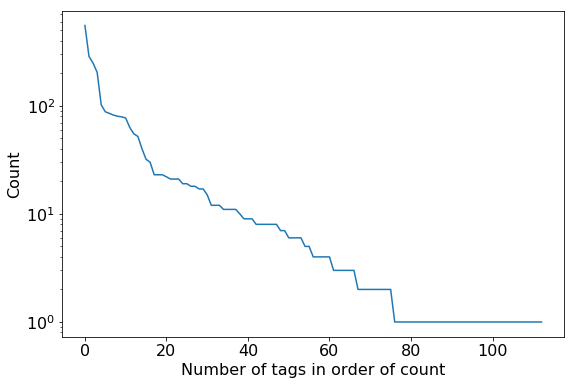

In [14]:
plt.rcParams.update({'font.size': 16})
ax = pd.Series(all_tags).str.lower().value_counts().reset_index(drop=True).plot(figsize=(9,6))
plt.xlabel('Number of tags in order of count')
plt.ylabel('Count')
plt.yscale('log')

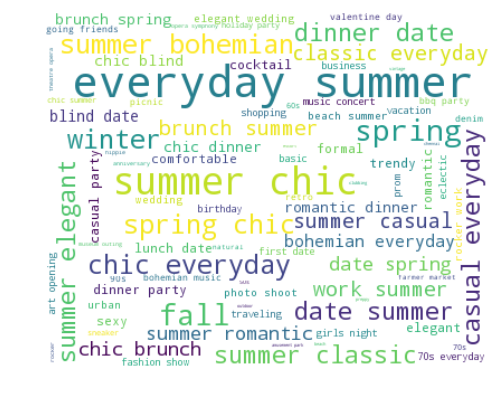

In [15]:
text = ' '.join(map(lambda s: s.lower(), all_tags))
wordcloud = WordCloud(max_words=200, background_color="white", height=320).generate(text)
plt.figure(figsize=(8,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()